# YOLOV8 and how to log predictions using Babylog

In this tutorial, we will learn the following:


*   How to run inference with YOLOV8 on a single image
*   How to log image and prediction data using [babylog](https://github.com/thebabylonai/babylog)
* How to load the logged binaries and view the logged information


# Pre-requisites
First, we will need to install `ultralytics` and `babylog`.

In [ ]:
!pip install babylog
!pip install ultralytics

# Running a YOLOV8 model on a sample image

In [ ]:
!wget https://ultralytics.com/images/bus.jpg

In [98]:
from ultralytics import YOLO
import cv2
 
model = YOLO("yolov8n.pt")  # loading a pretrained model, in this case the YOLOV8 nano model
img = cv2.imread("bus.jpg")

In [ ]:
import time
import numpy as np

times = []
for i in range(20):
  start_time = time.time()  # not using cuda time  measurement since inference is on cpu
  results = model(img)
  if i <= 3:  # discard first few measurements
    times.append(time.time() - start_time)
mean_latency = int(np.mean(times) * 1000)  # ms
print('Avg execution time (ms): {}'.format(mean_latency))


In [100]:
boxes = results[0].boxes.numpy()  # Boxes object for bbox outputs
boxes_xywh = boxes.xywh  # bounding boxes in x, y, width, height format
cls = boxes.cls  # detected classes
conf = boxes.conf # detection confidence

In [101]:
# convert the bounding boxes to babylog's format
boxes_babylog = [{'x': int(box[0]), 
                  'y': int(box[1]), 
                  'width': int(box[2]), 
                  'height': int(box[3]), 
                  'confidence': float(conf_),
                  'classification': {model.names[int(cls_)]: 1.0}}
                 for box, conf_, cls_ in zip(boxes_xywh, conf, cls)
                 ]  

## Logging CV inference using babylog

In [ ]:
!wget https://raw.githubusercontent.com/thebabylonai/babylog/master/python/resources/babylog.config.yaml

In [ ]:
import time
from babylog import Babylog, VisionModelType, InferenceDevice

bl = Babylog("babylog.config.yaml")  # save_local is True by default

bl.log(
    image=img,
    model_type=VisionModelType.DETECTION,
    model_name="yolov8n_pretrained",
    model_version="0.0.1",
    latency=mean_latency,
    inference_device=InferenceDevice.CPU,
    detection=boxes_babylog,
)

bl.shutdown()

# Viewing the logged information with babylog

In [104]:
import glob

logfile_path = glob.glob("./babylog/**/*.bin", recursive=True)[0]

In [105]:
from babylog import LoggedPrediction

logged_prediction = LoggedPrediction.from_path(logfile_path)  # from_path loads a prediction binary from path

In [106]:
predicted_image = logged_prediction.image  # raw image that was logged

In [107]:
from google.colab.patches import cv2_imshow
import numpy as np

for detection in logged_prediction.detection:
  x = detection['x']; y = detection['y']; w = detection['width']; h = detection['height']
  top_left = (x-w//2, y-h//2)
  bottom_right = (x+w//2, y+h//2)

  # visualizing the bounding boxes
  color = (np.array([0., 0., 1.]) * 255).astype(np.uint8).tolist()
  text = '{}:{:.1f}%'.format(detection['classificationResult'][0]['className'], detection['confidence'] * 100)
  txt_color = (255, 255, 255)
  font = cv2.FONT_HERSHEY_SIMPLEX
  txt_size = cv2.getTextSize(text, font, 0.8, 1)[0]

  cv2.rectangle(predicted_image, top_left, bottom_right, color, 2)
  txt_bk_color = (np.array([0.8, 0., 0.8]) * 255).astype(np.uint8).tolist()
  cv2.rectangle(
      predicted_image,
      (top_left[0], top_left[1] + 1),
      (top_left[0] + int(0.5*txt_size[0]) + 1, top_left[1] + int(1.5*txt_size[1])),
      txt_bk_color,
      -1
  )
  cv2.putText(predicted_image, text, (top_left[0], top_left[1] + txt_size[1]), font, 0.4, txt_color, thickness=1)

In [108]:
# Display inference stats
device = logged_prediction.inference_stats['inferenceDevice']
latency = logged_prediction.inference_stats['latency']
stats = 'Inference stats: {}, {}ms'.format(device, latency)
predicted_image = cv2.putText(predicted_image, stats, (50, 50), font, 1.0, (0., 255., 0.), thickness=2)

# Display model info
model_version = logged_prediction.model['version']
model_name = logged_prediction.model['name']
stats = 'Model info: {} v{}'.format(model_name, model_version)
predicted_image = cv2.putText(predicted_image, stats, (50, 100), font, 1.0, (0., 255., 0.), thickness=2)


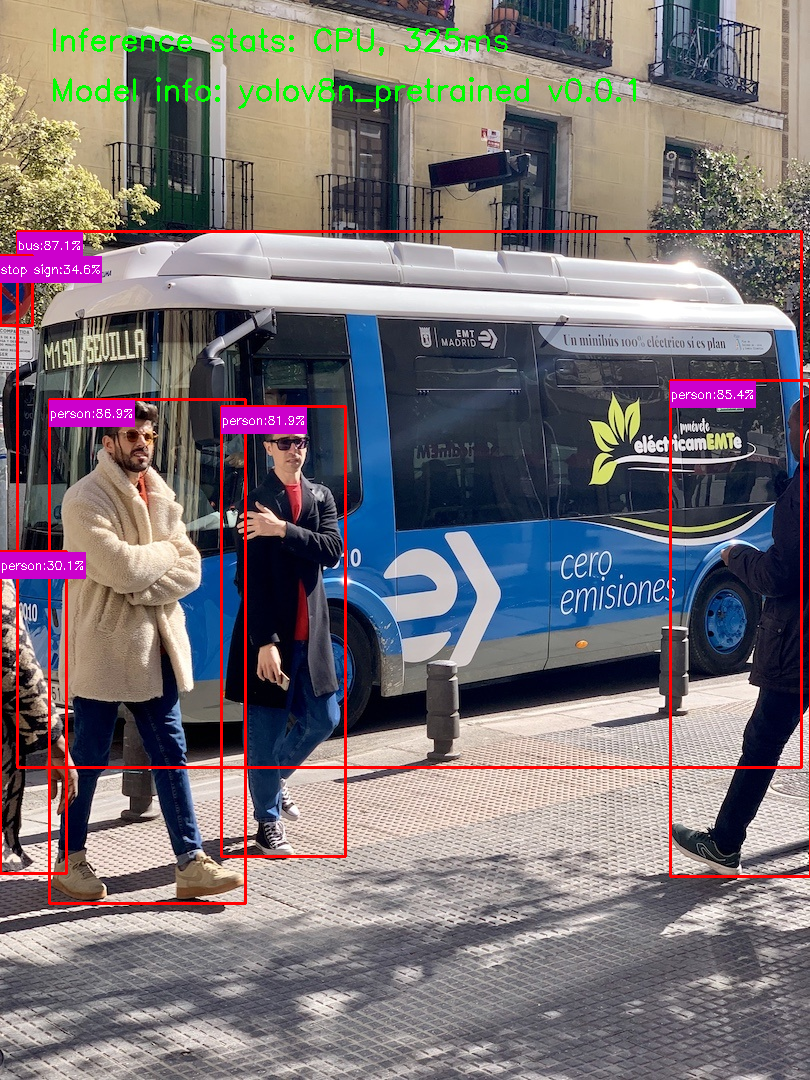

In [109]:
# Show image with inference result
cv2_imshow(predicted_image)